In [34]:
# handle imports, init ncb
import torch
import json
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from PIL import Image
import numpy as np
import pickle
import os
from neural_concept_binder import NeuralConceptBinder
import utils_ncb as utils_bnr
from torchvision import transforms
from argparse import Namespace
from datetime import datetime
import sglang as sgl
from sglang.srt.constrained import build_regex_from_object
from enum import Enum
from pydantic import BaseModel
from copy import deepcopy

# load Object Detection
sam2_checkpoint = "checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=torch.device("cuda"))
predictor = SAM2ImagePredictor(sam2_model)

# prepare ncb retrieval corpus
ncb_seed = 1
with open(
    f"/app/ncb/CLEVR-4/retbind_seed_{ncb_seed}/block_concept_dicts.pkl", "rb"
) as f:
    block_concepts = pickle.load(f)
with open(f"/app/ncb/CLEVR-4/retbind_seed_{ncb_seed}/all_img_locs.pkl", "rb") as f:
    all_img_locs = pickle.load(f)

# setup ncb
utils_bnr.set_seed(0)
args = Namespace(
    seed=0,
    batch_size=20,
    num_workers=0,
    image_size=128,
    image_channels=3,
    data_path="data/*.png",
    perc_imgs=1.0,
    log_path="../logs/",
    checkpoint_path=f"/app/ncb/CLEVR-4/retbind_seed_{ncb_seed}/best_model.pt",
    model_type="ncb",
    use_dp=False,
    name=datetime.now().strftime("%Y-%m-%d_%H:%M:%S"),
    num_categories=3,
    clf_type="dt",
    lr_dvae=0.0003,
    lr_enc=0.0001,
    lr_dec=0.0003,
    lr_warmup_steps=30000,
    lr_half_life=250000,
    clip=0.05,
    epochs=500,
    num_iterations=3,
    num_slots=4,
    num_blocks=16,
    cnn_hidden_size=512,
    slot_size=2048,
    mlp_hidden_size=192,
    num_prototypes=64,
    temp=1.0,
    temp_step=False,
    vocab_size=4096,
    num_decoder_layers=8,
    num_decoder_heads=4,
    d_model=192,
    dropout=0.1,
    tau_start=1.0,
    tau_final=0.1,
    tau_steps=30000,
    lr=0.01,
    binarize=False,
    attention_codes=False,
    retrieval_corpus_path=f"/app/ncb/CLEVR-4/retbind_seed_{ncb_seed}/block_concept_dicts.pkl",
    deletion_dict_path=None,
    merge_dict_path=None,
    retrieval_encs="proto-exem",
    majority_vote=False,
    topk=5,
    thresh_attn_obj_slots=0.98,
    thresh_count_obj_slots=1,  # -1 for all
    device="cuda",
)
utils_bnr.set_seed(0)
if args.model_type == "ncb":
    ncb_model = NeuralConceptBinder(args)
else:
    raise ValueError(f"Model type {args.model_type} not handled in this script!")
ncb_model.to(args.device)
ncb_model.eval()
torch.set_grad_enabled(True)

Loading retrieval corpus from /app/ncb/CLEVR-4/retbind_seed_1/block_concept_dicts.pkl ...

Number of concepts per block: 
[120, 5, 4, 5, 9, 2, 6, 8, 45, 213, 5, 189, 3, 4, 2, 239]

loaded .../app/ncb/CLEVR-4/retbind_seed_1/best_model.pt


In [35]:
# launch vlm server in separate terminal via:
# python -m sglang.launch_server --model-path lmms-lab/llava-onevision-qwen2-7b-ov --port 30000 --host 0.0.0.0 --chat-template chatml-llava

# after starting server somewhere else
from sglang.utils import wait_for_server

wait_for_server("http://localhost:30000")
sgl.set_default_backend(sgl.RuntimeEndpoint("http://localhost:30000"))

In [12]:
# dynamic programming table for storing already retrieved prototype information
prototype_table = {}

In [36]:
# define structured output
class color(str, Enum):
    brown = "brown"
    blue = "blue"
    yellow = "yellow"
    gray = "gray"
    green = "green"
    cyan = "cyan"
    red = "red"
    purple = "purple"


class shape(str, Enum):
    sphere = "sphere"
    cylinder = "cylinder"
    cube = "cube"


class material(str, Enum):
    rubber = "rubber"
    metal = "metal"


class size(str, Enum):
    small = "small"
    medium = "medium"
    large = "large"


class object_properties(BaseModel):
    color: color
    shape: shape
    material: material
    size: size

In [ ]:
# methods for ncb, attribute retrieval, showing images
def get_block_by_id(slot, block_id, args):
    """
    Grab the specific block from a given slot.
    """
    # make sure slot is just 1D individual slot
    assert len(slot.shape) == 1
    block_size = args.slot_size // args.num_blocks

    block = slot[block_id * block_size : (block_id + 1) * block_size]

    return block


def transform_np_slots_to_torch_slots(np_slots):
    slots = torch.tensor(np_slots).to("cuda")
    return slots.unsqueeze(0)


def torch_img_to_np_img(torch_img):
    assert torch_img.shape[0] == 1
    img = torch_img[0].detach().cpu().numpy()
    return np.transpose(img, (1, 2, 0))


def describe_encoding_via_prototypes(codes: list[int]):
    prototype_table_entry = prototype_table.get(tuple(codes), None)
    if prototype_table_entry is not None:
        return (
            prototype_table_entry[0],
            prototype_table_entry[1],
        )  # return attribute dict, prototype image

    else:
        # get all prototypes of that encoding
        prototype = np.zeros(args.slot_size, dtype=np.float32)
        for block_id, cluster_id in enumerate(codes):
            # grab block from base slot
            tmp_block = get_block_by_id(prototype, block_id, args)
            # replace this block with the copy of the new block slot
            tmp_block[:] = np.copy(
                block_concepts[block_id]["prototypes"]["prototypes"][cluster_id]
            )

        prototype_image = torch_img_to_np_img(
            ncb_model.model.decode(
                transform_np_slots_to_torch_slots(prototype).unsqueeze(0)
            )
        )
        prototype_image = Image.fromarray(
            (prototype_image * 255).clip(0, 255).astype("uint8")
        )
        attribute_dict = object_description_gen(prototype_image)
        prototype_table[tuple(codes)] = (attribute_dict, prototype_image)
        return attribute_dict, prototype_image


def get_negative_point(masks: np.ndarray, neighbor_radius=5):
    mask = masks[0]
    height, width = mask.shape
    offset = 10

    for y in range(offset, height - offset):  # Avoid edges
        for x in range(offset, width - offset):
            # Extract the 5x5 neighborhood centered at (y, x)
            neighborhood = mask[
                y - neighbor_radius : y + neighbor_radius + 1,
                x - neighbor_radius : x + neighbor_radius + 1,
            ]

            # Check if all values in the neighborhood are False
            if np.all(neighborhood == False):
                return (
                    x,
                    y,
                )  # Return the first coordinate (x, y) that satisfies the condition

    raise RuntimeError(
        "Could not find a pixel with an entirely False neighborhood. Reduce neighbor_radius"
    )


def mean_center_of_mask(mask):
    # Get the coordinates of all non-zero pixels (foreground pixels)
    foreground_pixels = np.column_stack(np.where(mask == 1))

    if foreground_pixels.shape[0] == 0:
        return None  # Return None if there are no foreground pixels

    # Calculate the mean center (centroid) by averaging the coordinates
    mean_y = np.mean(foreground_pixels[:, 0])  # Mean of y-coordinates (rows)
    mean_x = np.mean(foreground_pixels[:, 1])  # Mean of x-coordinates (columns)

    return (mean_x, mean_y)  # Return the (x, y) coordinates of the centroid


def reduce_attribute_dict(ad: dict) -> dict:
    reduced_dict = {}
    for key, value_list in ad.items():
        reference_value = value_list[0]
        varying_attribute = False
        for value in value_list:
            if value != reference_value:
                # TODO: introduce LLM back when ready
                # if are_concepts_similar(key, reference_value, value):
                #     reference_value = get_common_name(key, reference_value, value)
                # else:
                varying_attribute = True
                break
        if not varying_attribute:
            reduced_dict[key] = reference_value

    return reduced_dict


def approximate_position(x, y, image_width=128, image_height=128):
    cell_width = image_width // 3
    cell_height = image_height // 3

    # Classify the x coordinate (left, center, right)
    if x < cell_width:
        horizontal_position = "left"
    elif x < 2 * cell_width:
        horizontal_position = "center"
    else:
        horizontal_position = "right"

    # Classify the y coordinate (top, center, bottom)
    if y < cell_height:
        vertical_position = "top"
    elif y < 2 * cell_height:
        vertical_position = "center"
    else:
        vertical_position = "bottom"

    # Return the bin position
    return horizontal_position, vertical_position


def get_position_attribute(image_filenames: list[str]):
    # get position attribute
    horizontal_position_list = []
    vertical_position_list = []
    for image_name in image_filenames:
        image = Image.open(image_name)
        image = np.array(image.convert("RGB"))
        H, W, C = image.shape
        predictor.set_image(image)

        # select background
        input_box = np.array([0, 0, H, W])
        background_masks, scores, logits = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=input_box[None, :],
            multimask_output=False,
        )

        object_point = get_negative_point(background_masks)
        object_point = np.array([[object_point[0], object_point[1]]])
        object_label = np.array([1])

        object_masks, scores, logits = predictor.predict(
            point_coords=object_point, point_labels=object_label, multimask_output=False
        )
        mask_center = mean_center_of_mask(object_masks[0])
        horizintal_pos, vertical_pos = approximate_position(
            *mask_center, image_height=H, image_width=W
        )
        horizontal_position_list.append(horizintal_pos)
        vertical_position_list.append(vertical_pos)

    return horizontal_position_list, vertical_position_list


def get_example_filenames_from_block_cluster(
    block_id: int, cluster_id: int, num_examples: int = 10
):
    assert cluster_id <= len(
        block_concepts[block_id]["prototypes"]["ids"]
    ), "Cluster id exceeds number of clusters."
    num_examples = min(
        len(block_concepts[block_id]["exemplars"]["exemplar_ids"][cluster_id]),
        num_examples,
    )

    filepaths = []
    base_path = "/app/clevr_images/train/images/"

    for i in range(num_examples):
        id = block_concepts[block_id]["exemplars"]["exemplar_ids"][cluster_id][i]
        path = os.path.join(base_path, os.path.basename(all_img_locs[id]))
        filepaths.append(path)

    return filepaths


def get_ncb_encoding(img_fn: str, plot=False):
    # TODO: Why do I need to set a seed here for consistent results?
    utils_bnr.set_seed(0)

    img = Image.open(img_fn).convert("RGB")
    img.thumbnail((128, 128))
    transform = transforms.Compose(
        [
            transforms.CenterCrop((128, 128)),
            transforms.ToTensor(),
        ]
    )
    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0)  # add batch dimension

    codes, probs, slots, attns_vis, attns = ncb_model.encode(img_tensor)

    if plot:
        plot_attention_masks(img, img_tensor, attns, attns_vis)
        print(codes.numpy().astype(int))

    return codes, probs, slots, attns_vis, attns


def show_images_from_filenames(image_filenames: list[str]):
    fig, axs = plt.subplots(1, len(image_filenames))
    for i in range(len(image_filenames)):
        axs[i].imshow(imread(image_filenames[i]))
        axs[i].axis("off")
    plt.show()
    plt.close()


def show_images_from_PIL(images: list[Image.Image]):
    fig, axs = plt.subplots(1, len(images))
    for i in range(len(images)):
        axs[i].imshow(images[i])
        axs[i].axis("off")
    plt.show()
    plt.close()


def show_image_from_filename(image_filename: str):
    plt.imshow(imread(image_filename))
    plt.show()
    plt.close()


def show_image_from_PIL(image: Image.Image):
    plt.imshow(image)
    plt.show()
    plt.close()


@sgl.function
def object_description(s, image: str | Image.Image):
    s += sgl.user(
        sgl.image(image)
        + "Give me a description about the object in the image in the JSON format.\n"
    )
    s += sgl.gen(
        "object description",
        max_tokens=128,
        temperature=0.2,
        regex=build_regex_from_object(object_properties),  # Requires pydantic >= 2.0
    )


def object_description_gen(image: str | Image.Image):
    state = object_description.run(image)
    response = state.text()
    start_index = response.find("{")
    return json.loads(response[start_index:])


def show_exemplars(block_id: int, cluster_id: int, num_examples=10):
    image_filenames = get_example_filenames_from_block_cluster(
        block_id, cluster_id, num_examples=num_examples
    )
    show_images_from_filenames(image_filenames)


def plot_attention_masks(img, img_tensor, attns, attns_vis):
    # assume we only got one mask
    my_attns = attns.cpu().detach().numpy().squeeze(0).squeeze(0).squeeze(0)

    my_vis = attns_vis.cpu().detach().numpy().squeeze(0).squeeze(0)
    my_vis = np.transpose(my_vis, (1, 2, 0))

    img_tensor = img_tensor.cpu().detach().numpy().squeeze(0)
    img_tensor = np.transpose(img_tensor, (1, 2, 0))

    _, axs = plt.subplots(1, 4, figsize=(12, 12))
    axs[0].imshow(img)
    axs[0].set_title("Downsized input image")
    axs[1].imshow(img_tensor)
    axs[1].set_title("Input image tensor")
    axs[2].imshow(my_attns, cmap="grey")
    axs[2].set_title("Attention weights")
    axs[3].imshow(my_vis)
    axs[3].set_title("Attention weights * input tensor")
    plt.show()
    plt.close()

In [38]:
# define base paths for video frames
blackened_base_path = "/app/ncb/edited_videos/video_10000/cropped_images"
unedited_base_path = "/app/ncb/edited_videos/video_10003/video_frames"
square_base_path = "/app/ncb/square_imgs/video_10003"

# get image filenames
base_path = square_base_path
frame_names = sorted(os.listdir(base_path))
frame_names = [os.path.join(base_path, frame_name) for frame_name in frame_names]

# get ncb encodings
ncb_encodings = np.array(
    [get_ncb_encoding(fn, plot=False)[0].flatten() for fn in frame_names]
).astype(int)

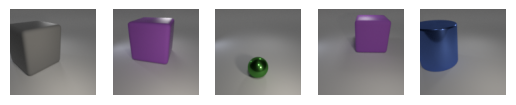

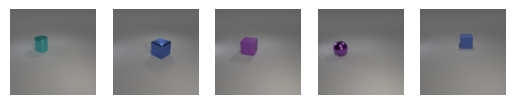

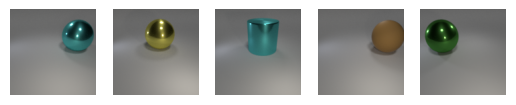

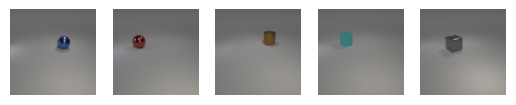

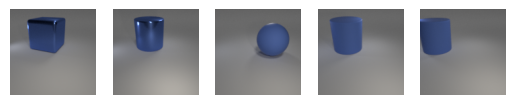

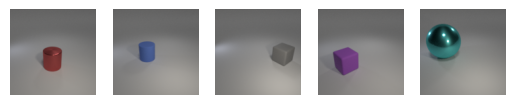

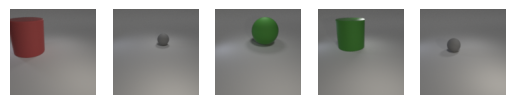

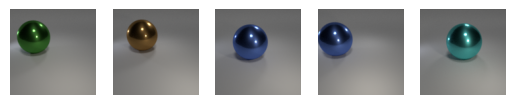

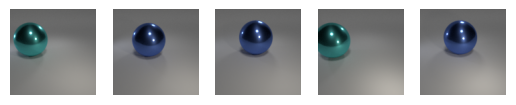

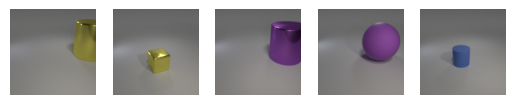

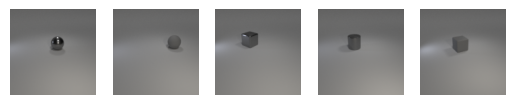

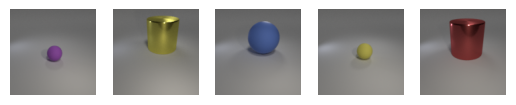

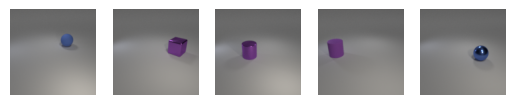

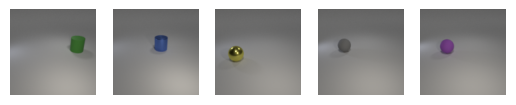

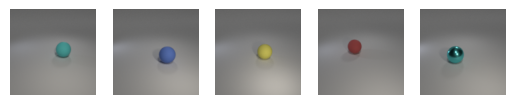

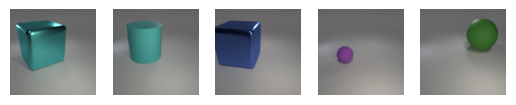

In [39]:
# visualize exemplars for each block of an encoding vector
encoding_to_look_at = ncb_encodings[0]

for i in range(len(encoding_to_look_at)):
    show_exemplars(i, encoding_to_look_at[i], num_examples=5)

In [ ]:
# use VLM to get attributes from decoded NCB prototypes (takes around 9 minutes for a whole video on a 4090 or takes 0 seconds if results are already cached in prototype_dict)
attribute_dicts, prototype_images = zip(*[describe_encoding_via_prototypes(codes) for codes in ncb_encodings])

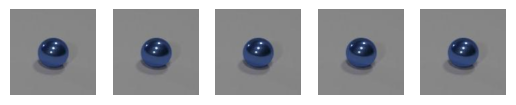

[[  5   0   3   1   7   0   3   0   5  11   2  49   2   1   0  37]
 [  5   0   3   1   7   0   3   0   5  11   2  49   2   1   0  50]
 [  5   0   3   1   7   0   3   0   5  11   2  49   2   1   0  78]
 [  5   0   3   1   7   0   3   0   5  11   2  49   2   1   0  37]
 [  5   0   3   1   7   0   3   0   5  11   2  49   2   1   0 101]]


In [41]:
# plot images and their ncb encodings
show_images_from_filenames(frame_names[0:5:1])
print(ncb_encodings[0:5:1])

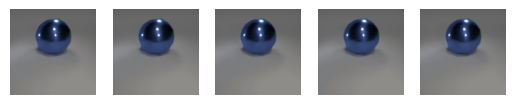

In [42]:
# show prototype images
show_images_from_PIL(prototype_images[0:5])

Original image:


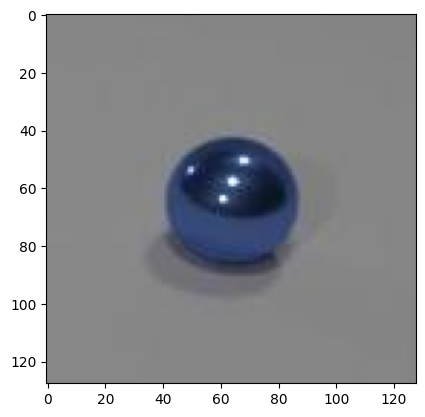

Prototype image:


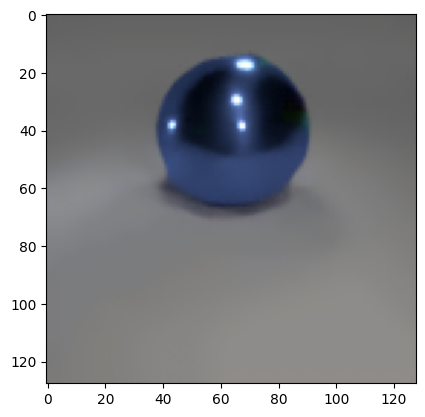

{'color': 'blue', 'shape': 'sphere', 'material': 'metal', 'size': 'small'}


In [46]:
# showcase of prototype reconstruction for attribute retrieval
frame_index = 0
attributes, prototype_image = describe_encoding_via_prototypes(ncb_encodings[frame_index])

# plot original image
print("Original image:")
show_image_from_filename(frame_names[frame_index])

# plot prototype image
print("Prototype image:")
show_image_from_PIL(prototype_image)

# attributes retrieved from prototype
print(attributes)

In [47]:
# Press attribute dicts into the same form as gt
def format_dicts(attributes: list[dict], format_keys: list[str]) -> list[dict]:
    formatted_list = []
    for att in attributes:
        formatted_dict = dict()
        for key in format_keys:
            formatted_dict[key] = att.get(key, None)
        formatted_list.append(formatted_dict)

    return formatted_list

In [48]:
# format dict for prototype attribute dicts
formatted_dicts = format_dicts(attribute_dicts, ["color", "material", "shape"])
print("formatted dicts:")
for fd in formatted_dicts:
    print(fd)

formatted dicts:
{'color': 'blue', 'material': 'metal', 'shape': 'sphere'}
{'color': 'blue', 'material': 'metal', 'shape': 'sphere'}
{'color': 'blue', 'material': 'metal', 'shape': 'sphere'}
{'color': 'blue', 'material': 'metal', 'shape': 'sphere'}
{'color': 'blue', 'material': 'metal', 'shape': 'sphere'}
{'color': 'blue', 'material': 'metal', 'shape': 'sphere'}
{'color': 'blue', 'material': 'metal', 'shape': 'sphere'}
{'color': 'blue', 'material': 'metal', 'shape': 'sphere'}
{'color': 'blue', 'material': 'metal', 'shape': 'sphere'}
{'color': 'blue', 'material': 'metal', 'shape': 'sphere'}
{'color': 'blue', 'material': 'metal', 'shape': 'sphere'}
{'color': 'blue', 'material': 'metal', 'shape': 'sphere'}
{'color': 'blue', 'material': 'metal', 'shape': 'sphere'}
{'color': 'blue', 'material': 'metal', 'shape': 'sphere'}
{'color': 'blue', 'material': 'metal', 'shape': 'sphere'}
{'color': 'blue', 'material': 'metal', 'shape': 'sphere'}
{'color': 'blue', 'material': 'metal', 'shape': 'sphere

In [49]:
# methods for assessing resulting attributes dicts
# assume you got two dicts with the same structure, check how many entries are the same
def compare_attribute_dicts(dict1: dict, dict2: dict):
    return np.mean([dict1[key] == dict2[key] for key in dict1])


def dict_accuracy_over_video(attribute_dicts: list[dict], gt: dict):
    return np.mean([compare_attribute_dicts(gt, ad) for ad in attribute_dicts])


def plot_attribute_correctness(formatted_dicts: list[dict], gt: dict):
    print(f"ground truth: {gt}")

    n, m = len(formatted_dicts), len(gt.keys())
    time = np.arange(n)
    fig, ax = plt.subplots(figsize=(10, 6))

    for t in time:
        y = 0
        for key in gt.keys():
            color = "green" if formatted_dicts[t][key] == gt[key] else "red"
            ax.barh(y, 1, left=t-0.5, color=color, edgecolor="black", height=0.75)
            y += 1

    # Formatting
    ax.set_yticks(range(m))
    ax.set_yticklabels([f"{key}" for key in gt.keys()])
    ax.set_xlabel("frame")
    ax.set_title("Correctness of retrieved attributes over time")
    ax.invert_yaxis()  # Optional: invert y-axis for better readability

    plt.tight_layout()
    plt.show()

Overall attribute accuracy: 0.9140625
ground truth: {'color': 'blue', 'material': 'metal', 'shape': 'sphere'}


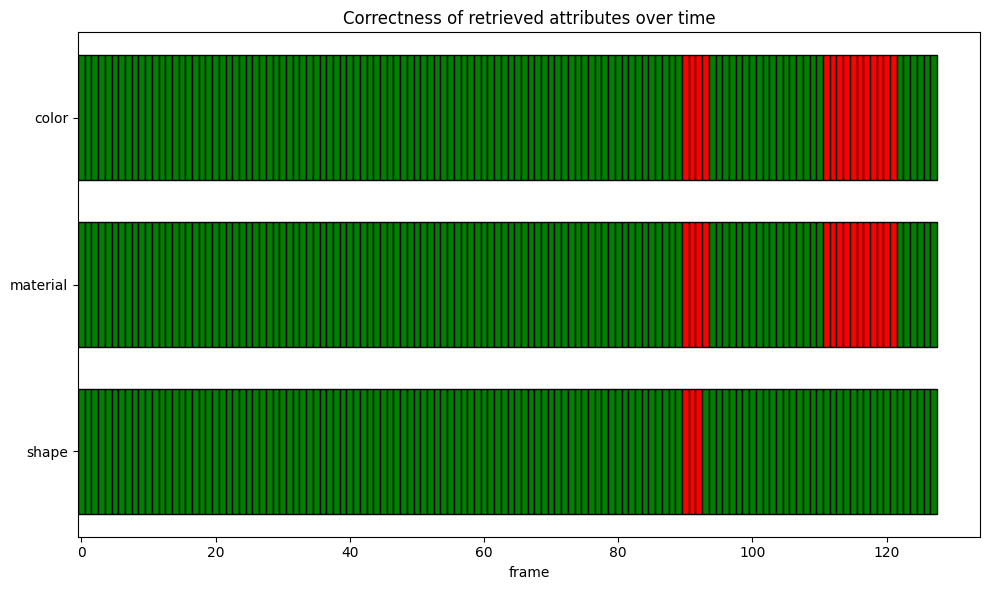

In [50]:
# plot correctness of attributes for video_10000
gt = {"color": "blue", "material": "metal", "shape": "sphere"}
print(f"Overall attribute accuracy: {dict_accuracy_over_video(formatted_dicts, gt)}")
plot_attribute_correctness(formatted_dicts, gt)